# Cell annotation - Pancreas human

With this notebook, we show the example of annotation of cell data with cell type based on marker genes. We propose a fast annotation procedure using the Mann-Whitney U test for genes selection and the Hypergeometric test for cell-type annotation. 

This example demonstrates the annotation procedure on Pancreas data [1]. 
For annotation, we use marker genes for cell types from PanglaoDB [2].

The whole annotation can be made by just calling one function, but since we want to show the intermediate results we will make the annotation in four steps: (1) Data normalization, (2) Selecting overexpressed genes with Mann-Whitney U test, (3) assigning the annotations with the hypergeometric test, and (4) filtering scores that do not meet p-value threshold.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
import seaborn as sn

from IPython.display import HTML, display
import tabulate

from pointannotator.annotate_samples import *
from pointannotator.plotting import confusion_matrix_plot, annotations_in_tsne_plot, confusion_matrix

In [3]:
Z_THRESHOLD = 1

### Data

Datasets are available [here](https://github.com/PrimozGodec/cell-annotation/releases/0.1.0) download them in data directory. If you are using unix based operating system it can be done with running:

In [4]:
!wget -q -nc -P data/ https://github.com/biolab/cell-annotation/releases/download/0.1.0/panglao_gene_markers.csv.gz
!wget -q -nc -P data/ https://github.com/biolab/cell-annotation/releases/download/0.1.0/GSM2230757_human1_umifm_counts.csv.gz
!wget -q -nc -P data/ https://github.com/biolab/cell-annotation/releases/download/0.1.0/GSM2230758_human2_umifm_counts.csv.gz
!wget -q -nc -P data/ https://github.com/biolab/cell-annotation/releases/download/0.1.0/GSM2230759_human3_umifm_counts.csv.gz
!wget -q -nc -P data/ https://github.com/biolab/cell-annotation/releases/download/0.1.0/GSM2230760_human4_umifm_counts.csv.gz

In [5]:
df1 = pd.read_csv("data/GSM2230757_human1_umifm_counts.csv.gz", compression="gzip")
df2 = pd.read_csv("data/GSM2230758_human2_umifm_counts.csv.gz", compression="gzip")
df3 = pd.read_csv("data/GSM2230759_human3_umifm_counts.csv.gz", compression="gzip")
df4 = pd.read_csv("data/GSM2230760_human4_umifm_counts.csv.gz", compression="gzip")

In [6]:
gene_expressions_df = pd.concat([df1, df2, df3, df4])

Since data are not normalized yet we will first nomralize them with log CPM normalization.

In [7]:
gene_expressions_normalized_df = AnnotateSamples.log_cpm(gene_expressions_df.loc[:, "A1BG":])

Data properties:

In [8]:
print("Number of cells in dataset: " + str(gene_expressions_normalized_df.shape[0]))
print("Number of genes in dataset: " + str(gene_expressions_normalized_df.shape[1]))

Number of cells in dataset: 8569
Number of genes in dataset: 20128


### Loading marker genes

We use marker genes from PanglaoDB. We packed marker genes in `.csv` file for easier loading. Marker genes must have `Cell Type` and `Gene` column.

In [9]:
marker_genes_df = pd.read_csv("data/panglao_gene_markers.csv.gz", compression="gzip")
marker_genes_df = marker_genes_df[marker_genes_df["Organism"] == "Human"]

Check the number of marker genes that overlap with genes in the dataset:

In [10]:
len(set(gene_expressions_normalized_df.columns.values) & set(marker_genes_df.loc[:, 'Name'].values))

4210

### Identifying highly expressed genes

With this step, we retrieve the z values for each gene-cell pair with Mann-Whitney U test. Z-value let us know whether the gene for this cell is higly expressed. In hypergeometric test later we will just consider genes that have a z-value above 1.

In [11]:
%%time
z_df = AnnotateSamples.mann_whitney_test(gene_expressions_normalized_df)

CPU times: user 47 s, sys: 5.81 s, total: 52.8 s
Wall time: 56.5 s


#### Statistics: Expressed genes per cell

The histogram shows the number of genes with z-value above 1 per cell.

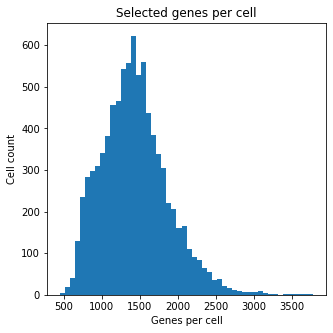

In [13]:
expressions_per_cell = (z_df > Z_THRESHOLD).sum(axis=1)
plt.figure(figsize=(5,5))
plt.hist(expressions_per_cell, bins=50);
plt.title("Selected genes per cell");
plt.xlabel("Genes per cell")
plt.ylabel("Cell count");

### Annotate

We use the hypergeometric test for annotation. It is made cell-vise. For each cell, it takes into account the number of genes by a cell type, number of genes selected for a cell by Mann-Whitney test, number of genes that overlap in the previous two sets and number of genes that the organism has. In our case, we take the number of genes discovered in the NCBI taxonomy database.

After the annotation scores that have a corrected p-value (FDR) below the threshold 0.05 are filtered out together with cell types that do not annotate any cell. The result is a scoring matrix where rows represent cells and columns represents cell-types.

In [17]:
%%time
scores_df, fdrs_df = AnnotateSamples.assign_annotations(
    z_df, marker_genes_df, gene_expressions_normalized_df, num_all_attributes=61244, attributes_col="Name",
    annotations_col="Cell Type")
# 61244 is number of genes in NCBI taxonomy database for human 
annotations_df = AnnotateSamples.filter_annotations(
    scores_df, fdrs_df, return_nonzero_annotations=True, p_threshold=0.05)

annotation_labels = annotations_df.idxmax(axis=1)  # get the index of a maximal score per cell

CPU times: user 13.7 s, sys: 1.1 s, total: 14.8 s
Wall time: 14.2 s


#### Statistics: 10 most common labels

Here we show what are the most common cell-tyepes in this dataset.

In [18]:
counts = Counter(annotation_labels).most_common()
counts_show = [[k, "{:.03f}".format(v / len(annotation_labels))] for k, v in counts[:10]]

display(HTML("10 most common labels in the dataset and proportion of appearance"))
display(HTML(tabulate.tabulate(counts_show, tablefmt='html')))

Alpha cells,0.213
Beta cells,0.212
Acinar cells,0.155
Delta cells,0.063
Ductal cells,0.061
Pancreatic stellate cells,0.051
Transient cells,0.039
Gamma (PP) cells,0.027
Pancreatic progenitor cells,0.02
Endothelial cells,0.018


### Comparison with dataset annotations

To check whether the annotation is relevant we plot a confusion matrix, where columns represent cell types which annotated by dataset authors and rows represent annotations by our technique.

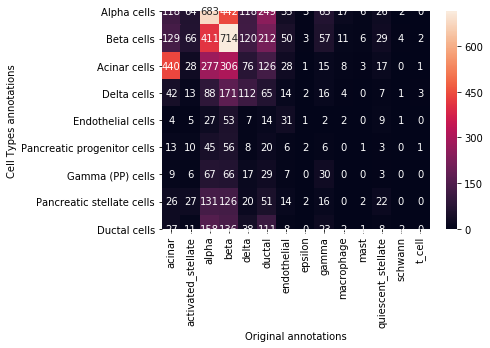

In [20]:
confusion_matrix_plot(annotations_df, gene_expressions_df["assigned_cluster"].values)

### Annotations in tSNE plot

We reduce dimensionality of cell-data with the tSNE and then assign most common cell-type to groups in the tSNE plot. The dimensionality reduction is performed by openTSNE [3] the fast tSNE implementation. Groups are identified by DBSCAN.

/Users/primoz/venv/orange/lib/python3.7/site-packages/openTSNE/nearest_neighbors.py:184: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  "`pynndescent` has recently changed which distance metrics are supported, "


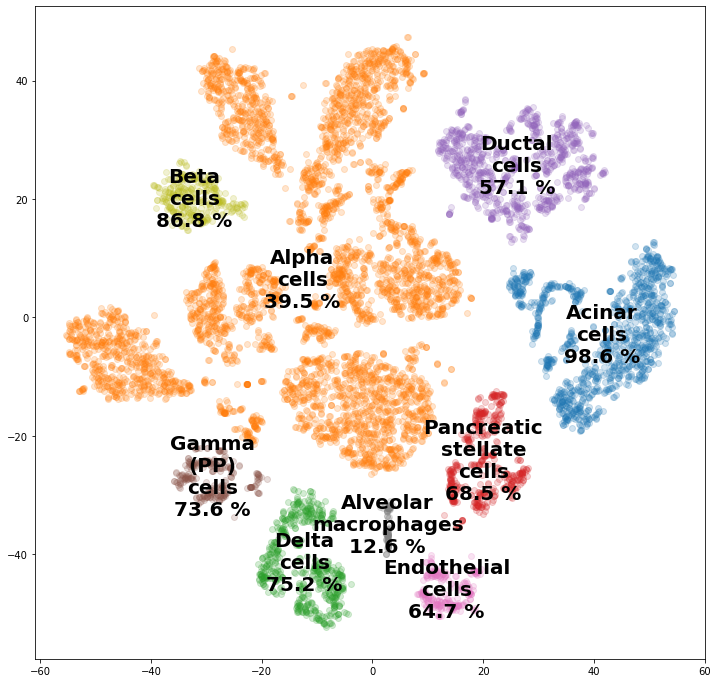

In [22]:
plt.figure(figsize=(12, 12))
annotations_in_tsne_plot(gene_expressions_normalized_df, annotations_df, num_annot=1, eps=4)

### Cells-genes heatmap

For each cell, we select a few genes with the highest z-value and show their expressions. With this plot, we show that selected genes separate this cell type from other cell types. We show that the hypergeometric test selected the type that is described with shown genes.

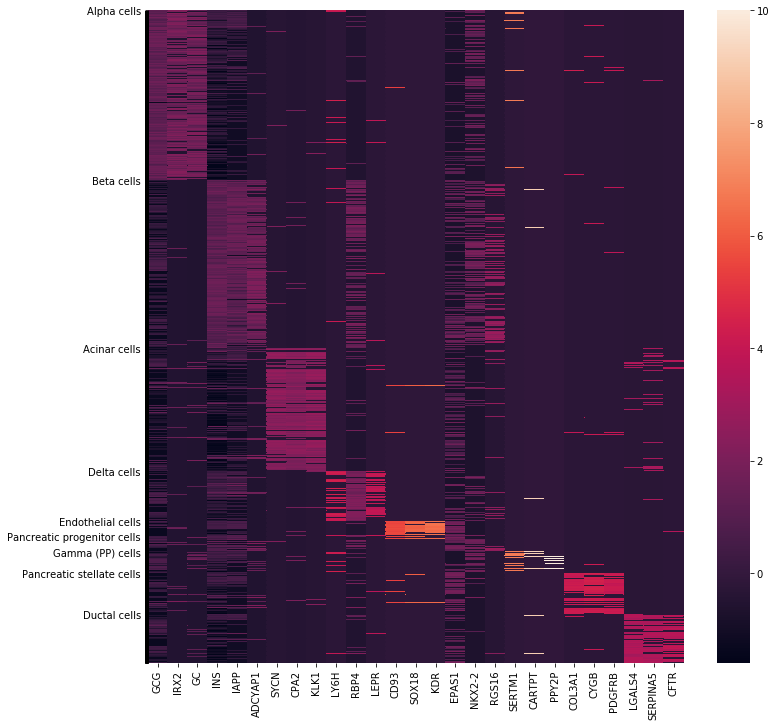

In [25]:
plt.figure(figsize=(12, 12))
n_genes_per_type = 3

# select genes with highest z-score for a cell in a group
selected_cells = np.array([]).astype(int)
selected_genes = np.array([]).astype(int)
y_tick_labels = []

_, labels_unique_sub, _ = confusion_matrix(annotations_df, gene_expressions_df["assigned_cluster"].values)

for cell_type in labels_unique_sub:
    z_values_type = z_df[annotation_labels == cell_type]
    genes_idx = z_values_type.mean(axis=0).argsort()[-n_genes_per_type:]
    selected_genes = np.concatenate([selected_genes, genes_idx])
    
    cells_idx1 = np.where(annotation_labels == cell_type)[0]
    selected_cells = np.concatenate([selected_cells, cells_idx1])
    
    y_tick_labels += [cell_type] + [""] * (len(cells_idx1) - 1)


hm_array_df = z_df.iloc[selected_cells].iloc[:, selected_genes]
# hm_array_df = pd.DataFrame(hm_array, columns=genes_names[selected_genes])
hm_array_df = hm_array_df.clip(-100, 10)
sn.heatmap(hm_array_df, yticklabels=y_tick_labels);

### Bibliography

[1]    ??

[2]    Oscar Franzén, Li-Ming Gan, Johan L M Björkegren, PanglaoDB: a web server for exploration of mouse and human single-cell RNA sequencing data, Database, Volume 2019, 2019.

[3]    Poličar, P. G., Stražar, M., & Zupan, B. (2019). openTSNE: a modular Python library for t-SNE dimensionality reduction and embedding. BioRxiv, 731877. 